# Урок 4. Деревья решений

1. В коде из методички реализуйте один или несколько критериев останова: минимальное количество объектов в листе (`min_leaf`), максимальная глубина дерева, максимальное количество листьев и т.д. Добавьте эти критерии в параметры функции `build_tree` и проверьте ее работоспособность с помощью визуализации дерева. 

In [752]:
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

In [753]:
class ColorText:
    PURPLE = '\033[1;35;48m'
    CYAN = '\033[1;36;48m'
    BOLD = '\033[1;39;48m'
    GREEN = '\033[1;34;48m'
    BLUE = '\033[1;44;48m'
    ORANGE = '\033[1;32;48m'
    YELLOW = '\033[1;33;48m'
    RED = '\033[1;31;48m'
    BLACK = '\033[1;30;48m'
    UNDERLINE = '\033[1;37;48m'
    END = '\033[1;37;0m'

In [754]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(ColorText.ORANGE + spacing + ' ЛИСТ' 
                  + ': прогноз = ' + str(node.prediction)
                  + ', объектов = ' + str(len(node.labels))
                  + ColorText.END)
        return

    # Выведем значение индекса и порога на этом узле
    print(ColorText.GREEN + spacing + ' УЗЕЛ'  
              + ': индекс = ' + str(node.index) 
              + ', порог = ' + str(round(node.t, 2))
              + ', глубина = ' + str(node.depth)
              + ', leafs = ' + str(node.count_leafs)
              + ColorText.END)

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> Левая ветка:')
    print_tree(node.true_branch, spacing + "   ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> Правая ветка:')
    print_tree(node.false_branch, spacing + "   ")
    

In [755]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

### построение модели

In [756]:
# Класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch, depth, count_leafs):
        self.index = index # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t # значение порога
        self.true_branch = true_branch # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch # поддерево, не удовлетворяющее условию в узле
        self.depth = depth
        self.count_leafs = count_leafs

In [757]:
# Класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data, self.labels = data, labels
        self.prediction = self.predict()
        
    def predict(self):
        #подсчет количества объектов разных классов
        class_, count_ = np.unique(self.labels, return_counts=True)
        classes = dict(zip(class_, count_))
        # надем класс, количество объектов которого будет максимальным в этом листе и вернем его
        prediction = max(classes, key=classes.get)
        return prediction

Критерий Энтропии Шенона:
$$H(X) = - \sum^{K}_{k=1}p_{k}\text{log}_{2}p_{k}.$$

In [758]:
# # расчет критерия Энтропии Шенона

# def shenon(labels):
#     # подсчет количества объектов разных классов
#     class_, count_ = np.unique(labels, return_counts=True)
#     classes = dict(zip(class_, count_))
    
#     # расчет критерия
#     impurity = - sum([classes[label] / len(labels) * np.log2(classes[label] / len(labels))  for label in classes])
    
#     return impurity

Индекс Джини:
$$H(X) = 1 - \sum^{K}_{k=1}p_{k}^{2}.$$

In [759]:
# расчет критериев

def criterion(labels, name_criterion='gini'):
    # подсчет количества объектов разных классов
    class_, count_ = np.unique(labels, return_counts=True)
    classes = dict(zip(class_, count_))
    
    if name_criterion == 'gini':
        # расчет критерия Джини
        impurity = 1 - sum([(classes[label] / len(labels)) ** 2 for label in classes]) 
    else:
        # расчет критерия Энтропии Шенона
        impurity = - sum([classes[label] / len(labels) * np.log2(classes[label] / len(labels))  for label in classes])
        
    return impurity

In [760]:
# Функционал качества

def quality(left_labels, right_labels, current_criterion, name_criterion='gini'):
    
    # Доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0] / (left_labels.shape[0] + right_labels.shape[0]))
    
    if name_criterion == 'gini':
        Q = current_criterion - p * criterion(left_labels) - (1 - p) * criterion(right_labels)
    else:
        Q = current_criterion - p * criterion(left_labels, name_criterion='entropy') - (1 - p) * criterion(right_labels, name_criterion='entropy')
    
    return Q

In [761]:
# разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
    
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
    
    return true_data, false_data, true_labels, false_labels

In [762]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_samples_leaf=1, name_criterion='gini'):
    
    current_criterion = criterion(labels, name_criterion=name_criterion)
    
    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            # пропуск разделения при меньшем количестве объектов в одном из узлов, чем min_samples_leaf
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
        
            current_quality = quality(true_labels, false_labels, current_criterion, name_criterion=name_criterion)
            
            # выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index
                
    return best_quality, best_t, best_index  

In [763]:
def build_tree(data, labels, min_samples_leaf=1, criterion="gini",
               max_depth=999, depth=0, max_leafs=999, count_leafs= 1):
    
    quality, t, index = find_best_split(data, labels, min_samples_leaf, name_criterion=criterion)
    
    # Базовый случай - прекращение рекурсии, когда нет прироста в качестве
    if quality == 0:
        return Leaf(data, labels)
    
    # Случай при превышении количества узлов в глубь дерева
    if depth == max_depth:
        return Leaf(data, labels)
    else:
        new_depth = depth + 1
    
    # Случай при превышении максимального количества листьев
    if count_leafs * 2 > max_leafs:
        return Leaf(data, labels)
    else:
        count_leafs = count_leafs * 2
     
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, min_samples_leaf=min_samples_leaf,
                             criterion=criterion, max_depth=max_depth, depth=new_depth,
                             max_leafs=max_leafs, count_leafs=count_leafs)
    
    
    false_branch = build_tree(false_data, false_labels, min_samples_leaf=min_samples_leaf,
                              criterion=criterion, max_depth=max_depth, depth=new_depth,
                              max_leafs=max_leafs, count_leafs=count_leafs)
    
    # возвращаем класс узла со всеми поддеревьями
    return Node(index, t, true_branch, false_branch, new_depth, count_leafs)

In [764]:
def classify_object(obj, node):
    
    # Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [765]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
        
    return classes

### Пример работы модели

In [766]:
# генерация данных
classification_data, classification_labels = datasets.make_classification(n_samples=500,
                                                                         n_features=2,
                                                                         n_informative=2,
                                                                         n_classes=2,
                                                                         n_redundant=0,
                                                                         n_clusters_per_class=1,
                                                                         random_state=89
                                                                         )

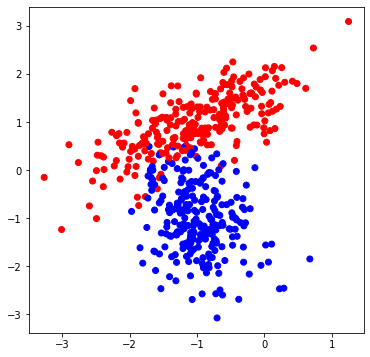

In [767]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(6,6))
plt.scatter(list(map(lambda x: x[0], classification_data)),
            list(map(lambda x: x[1], classification_data)),
            c=classification_labels,
            cmap=colors
           )
plt.show()

In [768]:
train_data, test_data, train_labels, test_labels = train_test_split(classification_data,
                                                                   classification_labels,
                                                                   test_size=0.3,
                                                                   random_state=89)

In [769]:
# Построение дерева по обучающей выборке

my_tree = build_tree(train_data, train_labels, criterion='entropy',
                     max_depth=5, min_samples_leaf=5,
                     max_leafs=16)

In [770]:
train_answers = predict(train_data, my_tree)

answers = predict(test_data, my_tree)

Меткость на обучающей выборке

In [771]:
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Меткость на обучающей выборке = {train_accuracy}')

Меткость на обучающей выборке = 97.42857142857143


In [772]:
test_accuracy = accuracy_metric(test_labels, answers)
print(f'Меткость на тестовой выборке = {test_accuracy}')

Меткость на тестовой выборке = 91.33333333333333


In [773]:
print_tree(my_tree)

 УЗЕЛ: индекс = 1, порог = 0.05, глубина = 1, leafs = 2
--> Левая ветка:
    УЗЕЛ: индекс = 0, порог = -1.89, глубина = 2, leafs = 4
   --> Левая ветка:
       ЛИСТ: прогноз = 0, объектов = 7
   --> Правая ветка:
       УЗЕЛ: индекс = 0, порог = -1.56, глубина = 3, leafs = 8
      --> Левая ветка:
          УЗЕЛ: индекс = 0, порог = -1.64, глубина = 4, leafs = 16
         --> Левая ветка:
             ЛИСТ: прогноз = 1, объектов = 11
         --> Правая ветка:
             ЛИСТ: прогноз = 1, объектов = 5
      --> Правая ветка:
          ЛИСТ: прогноз = 1, объектов = 157
--> Правая ветка:
    УЗЕЛ: индекс = 1, порог = 0.51, глубина = 2, leafs = 4
   --> Левая ветка:
       УЗЕЛ: индекс = 0, порог = -1.72, глубина = 3, leafs = 8
      --> Левая ветка:
          ЛИСТ: прогноз = 0, объектов = 15
      --> Правая ветка:
          УЗЕЛ: индекс = 0, порог = -1.17, глубина = 4, leafs = 16
         --> Левая ветка:
             ЛИСТ: прогноз = 0, объектов = 13
         --> Правая ветка:
      

Text(0.5, 1.0, 'Test accuracy=91.33')

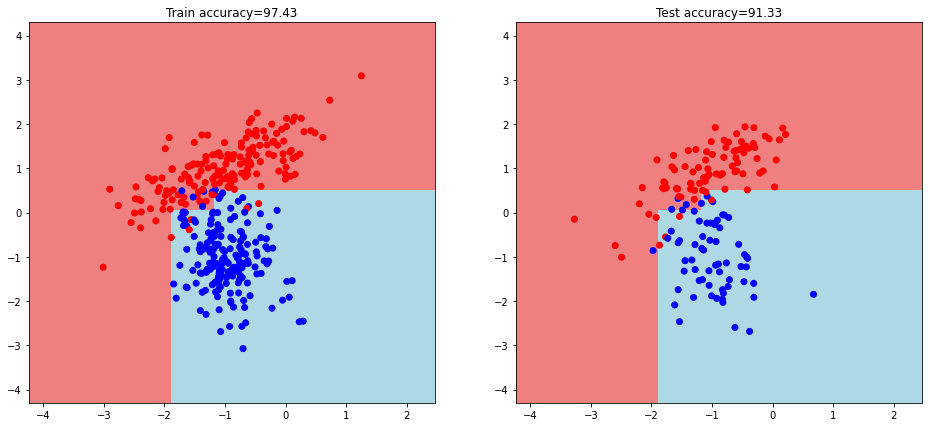

In [774]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=0.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

2. (\*) Для задачи классификации обучите дерево решений с использованием критериев разбиения Джини и Энтропия. Сравните качество классификации, сделайте выводы.

In [775]:
# Построение дерева по обучающей выборке

#Критерий энтропии Шенона
my_tree_entropy = build_tree(train_data, train_labels, criterion='entropy')

#Критерий Джини
my_tree_gini = build_tree(train_data, train_labels, criterion='gini')

In [776]:
answers_entropy = predict(test_data, my_tree_entropy)

answers_gini = predict(test_data, my_tree_gini)

Точность при критерии энтропии Шенона:

In [777]:
accuracy_metric(test_labels, answers_entropy)

91.33333333333333

Точность при критерии Джини:

In [778]:
accuracy_metric(test_labels, answers_gini)

90.0

*При расчете качества деления лучше себя показывает критерий энтропии Шенона, чем индекс Джини.*

3. (\*) Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, а критерий Джини на дисперсию значений. Проверьте точность предсказания дерева на одной из метрик задачи регрессии.

In [779]:
# генерация данных
regression_data, regression_labels = datasets.make_regression(n_samples=500,
                                                              n_features=1,
                                                              n_informative=1,
                                                              noise=50,
                                                              shuffle=True,
                                                              n_targets=1,
                                                              random_state=89
                                                             )

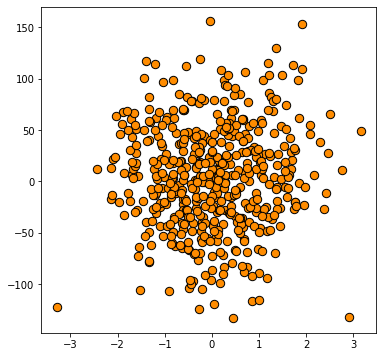

In [780]:
# Визуализация регрессии
plt.figure(figsize=(6,6))
plt.scatter(regression_data, regression_labels, c='darkorange', edgecolor='black', s=70);

Критерий информативности:

$$H(X) = \frac{1}{|X|}\sum_{i\in X}(y_{i} - \bar{y})^{2},$$

где $\bar{y}$ - среднее значение ответа в выборке $X$:

$$\bar{y} = \frac{1}{|X|}\sum_{i\in X}y_{i}.$$

In [781]:
# расчет критерия информативности регрессии

def criterion(labels, name_criterion='reg'):
    
    n = labels.shape[0] # количество объектов в узле
    y_mean = labels.mean() # среднее значение в узле
    
    # impurity (H(X))
    return sum([(y - y_mean) ** 2 for y in labels]) / n

In [782]:
# Функционал качества

def quality(left_labels, right_labels, current_criterion, name_criterion='reg'):
    
    # Доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0] / (left_labels.shape[0] + right_labels.shape[0]))
    
    return current_criterion - p * criterion(left_labels) - (1 - p) * criterion(right_labels)

In [783]:
# Класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data, self.labels = data, labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов в листе
        n = self.labels.shape[0]
        
        # подсчет среднего значения в листе
        prediction = self.labels.mean()
        
        return prediction

In [784]:
# функция метрики среднеквадратичной ошибки под корнем rmse
def rmse_metric(true_labels, answers):
    n = true_labels.shape[0]
    return np.sqrt(np.sum([(answers[i] - true_labels[i]) ** 2 for i in range(n)]) / n)

In [785]:
train_data, test_data, train_labels, test_labels = train_test_split(regression_data,
                                                                   regression_labels,
                                                                   test_size=0.3,
                                                                   random_state=89)

In [786]:
my_regression_tree = build_tree(train_data, train_labels, criterion='reg', min_samples_leaf=8
                               , max_leafs=16)

In [787]:
print_tree(my_regression_tree)

 УЗЕЛ: индекс = 0, порог = 1.18, глубина = 1, leafs = 2
--> Левая ветка:
    УЗЕЛ: индекс = 0, порог = -1.61, глубина = 2, leafs = 4
   --> Левая ветка:
       УЗЕЛ: индекс = 0, порог = -1.74, глубина = 3, leafs = 8
      --> Левая ветка:
          ЛИСТ: прогноз = 22.4464762274656, объектов = 12
      --> Правая ветка:
          ЛИСТ: прогноз = 30.369986588947434, объектов = 13
   --> Правая ветка:
       УЗЕЛ: индекс = 0, порог = 0.16, глубина = 3, leafs = 8
      --> Левая ветка:
          УЗЕЛ: индекс = 0, порог = -0.67, глубина = 4, leafs = 16
         --> Левая ветка:
             ЛИСТ: прогноз = 5.014808070715506, объектов = 63
         --> Правая ветка:
             ЛИСТ: прогноз = -12.26969267145748, объектов = 100
      --> Правая ветка:
          УЗЕЛ: индекс = 0, порог = 0.5, глубина = 4, leafs = 16
         --> Левая ветка:
             ЛИСТ: прогноз = 16.426299436645785, объектов = 47
         --> Правая ветка:
             ЛИСТ: прогноз = -7.123943928549503, объектов = 64

In [788]:
train_answers = predict(train_data, my_regression_tree)

In [789]:
test_answers = predict(test_data, my_regression_tree)

In [790]:
train_rmse = rmse_metric(train_labels, train_answers)
print(f'Ошибка на обучающей выборке = {train_rmse}')

Ошибка на обучающей выборке = 48.882862393130516


In [791]:
test_rmse = rmse_metric(test_labels, test_answers)
print(f'Ошибка на обучающей выборке = {test_rmse}')

Ошибка на обучающей выборке = 49.99816235305698


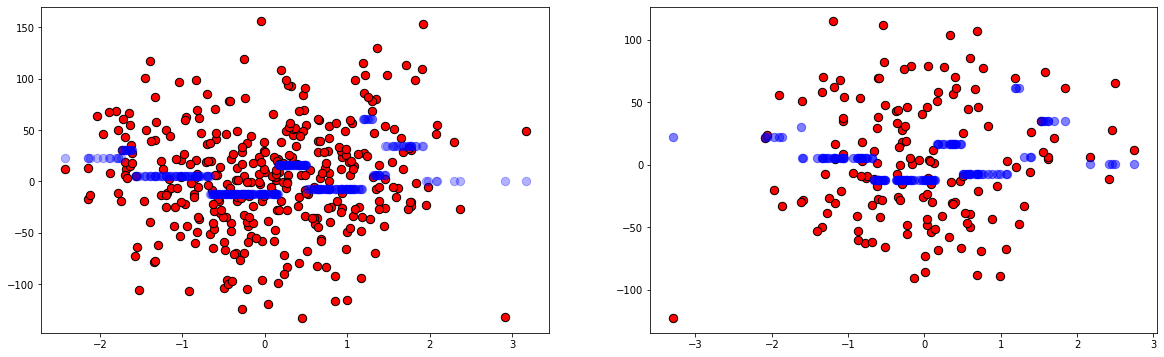

In [792]:
# Визуализация регрессии
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.scatter(train_data, train_labels, c='red', edgecolors='black', s=70);

plt.scatter(train_data, train_answers, c='blue', alpha=0.3, s=70)

plt.subplot(1,2,2)
plt.scatter(test_data, test_labels, c='red', edgecolors='black',  s=70);

plt.scatter(test_data, test_answers, c='blue', alpha=0.5, s=70)
plt.show()